This notebook recreates Figures 2 and 3 from 

Kozlowski, Austin C., Taddy, Matt, and  Evans, James A.  
    2019 "The Geometry of Culture: Analyzing the Meanings of Class through Word Embeddings"
    *American Sociological Review* 84(5):905–949.
    
In lieu of the Google n-grams dataset used in the paper, a corpus of blog posts from Kaggle is analyzed:

Blog authorship corpus  
https://www.kaggle.com/rtatman/blog-authorship-corpus

In [1]:
import csv
import gensim
import numpy as np
import sys
import word2vec
import word_pairs
csv.field_size_limit(sys.maxsize)

131072

Remove NUL bytes

In [4]:
data = open("data/blogtext.csv", "rb").read()
fo = open("data/blogclean.csv", "wb")
fo.write(data.replace(b"\x00", b""))

800376866

Split up blog corpus by age group - teens (13-17), twenties (23-27), thirties (33-47)

In [7]:
teenfile = open("data/blog10s.txt", "w")
twentyfile = open("data/blog20s.txt", "w")
thirtyfile = open("data/blog30s.txt", "w")
with open("data/blogclean.csv") as blogtext:
    reader = csv.DictReader(blogtext)
    count = 1
    for record in reader:
        if int(record["age"]) < 20:
            teenfile.write(record["text"]+"\n")
        elif int(record["age"]) < 30:
            twentyfile.write(record["text"]+"\n")
        else:
            thirtyfile.write(record["text"]+"\n")        
teenfile.close()
twentyfile.close()
thirtyfile.close()

Convert to files to phrases

In [8]:
word2vec.word2phrase('data/blog10s.txt', 'data/blog10-phrases.txt', verbose=True)
word2vec.word2phrase('data/blog20s.txt', 'data/blog20-phrases.txt', verbose=True)
word2vec.word2phrase('data/blog30s.txt', 'data/blog30-phrases.txt', verbose=True)

Running command: word2phrase -train data/blog10s.txt -output data/blog10-phrases.txt -min-count 5 -threshold 100 -debug 2
Starting training using file data/blog10s.txt
Words processed: 44300K     Vocab size: 12325K  ds processed: 29500K     Vocab size: 9015K   processed: 31000K     Vocab size: 9382K  
Vocab size (unigrams + bigrams): 6673598
Words in train file: 44339527
Running command: word2phrase -train data/blog20s.txt -output data/blog20-phrases.txt -min-count 5 -threshold 100 -debug 2
Starting training using file data/blog20s.txt
Words processed: 65600K     Vocab size: 16234K  ed: 14400K     Vocab size: 5040K  s processed: 35000K     Vocab size: 10040K  ocessed: 56000K     Vocab size: 14389K   processed: 62200K     Vocab size: 15600K  
Vocab size (unigrams + bigrams): 8791751
Words in train file: 65666276
Running command: word2phrase -train data/blog30s.txt -output data/blog30-phrases.txt -min-count 5 -threshold 100 -debug 2
Starting training using file data/blog30s.txt
Words pro

Create models

In [9]:
word2vec.word2vec('data/blog10-phrases.txt', 'data/blog10.bin', size=100, binary=True, verbose=True)
word2vec.word2vec('data/blog20-phrases.txt', 'data/blog20.bin', size=100, binary=True, verbose=True)
word2vec.word2vec('data/blog30-phrases.txt', 'data/blog30.bin', size=100, binary=True, verbose=True)

Running command: word2vec -train data/blog10-phrases.txt -output data/blog10.bin -size 100 -window 5 -sample 1e-3 -hs 0 -negative 5 -threads 12 -iter 5 -min-count 5 -alpha 0.025 -debug 2 -binary 1 -cbow 1
Starting training using file data/blog10-phrases.txt
Vocab size: 267751
Words in train file: 41113901
Alpha: 0.000002  Progress: 100.00%  Words/thread/sec: 167.20k  k  ogress: 1.89%  Words/thread/sec: 169.79k  69.81k  .024054  Progress: 3.79%  Words/thread/sec: 170.61k  read/sec: 170.75k  ec: 170.34k  Progress: 8.42%  Words/thread/sec: 170.76k  7%  Words/thread/sec: 170.54k  Progress: 13.67%  Words/thread/sec: 170.31k  ec: 170.35k  06k  70.01k  3k  ess: 23.94%  Words/thread/sec: 169.30k   Progress: 28.11%  Words/thread/sec: 168.83k  read/sec: 168.27k  .44%  Words/thread/sec: 168.35k  thread/sec: 168.35k  3k    167.87k    Progress: 38.77%  Words/thread/sec: 167.77k  : 0.015169  Progress: 39.33%  Words/thread/sec: 167.78k  ogress: 39.80%  Words/thread/sec: 167.75k  pha: 0.014722  Progre

Load Word2Vec models

In [2]:
model10 = gensim.models.KeyedVectors.load_word2vec_format("data/blog10.bin", binary=True, unicode_errors="ignore")
model20 = gensim.models.KeyedVectors.load_word2vec_format("data/blog20.bin", binary=True, unicode_errors="ignore")
model30 = gensim.models.KeyedVectors.load_word2vec_format("data/blog30.bin", binary=True, unicode_errors="ignore")

Define some utility functions

In [76]:
def get_vectors(model, words):
    """
    Return a list of pairs of word vectors corresponding to a list
    of antonym pairs
    """
    result = []
    for pair in words:
        try:
            result.append((model[pair[0]], model[pair[1]]))
        except KeyError:
            # skip words that do not appear in corpus
            continue
    return result

def get_dimension(model, words):
    """
    Calculate the cultural dimension of a list of antonym pairs
    Per Kozlowski 2019 this is the mean of the differences
    of the word pairs
    """
    # Calculate the cultural dimension of a list of antonym pairs
    
    vectors = get_vectors(model, words)
    return sum([v[0]-v[1] for v in vectors]) / len(vectors)

def vector_projection(vector, dimension):
    """
    Calculate the vector projection of vector along the specified dimension
    """

    return (dimension / np.linalg.norm(dimension)) * np.dot(vector, dimension)

def scalar_projection(vector, dimension):
    """
    Calculate the scalar projection of vector along the specified dimension
    """

    return np.dot(vector, dimension) / np.linalg.norm(dimension)

def get_angle(vector, dimension):
    """
    Calculate the angle between the vector and the given dimension
    """
    v_dot_d = np.dot(vector, dimension)
    v_d = np.linalg.norm(vector) * np.linalg.norm(dimension)
    c = v_dot_d / v_d
    return np.degrees(np.arccos(np.clip(c, -1, 1)))

Calculate the cultural dimension vectors for each dimension and each model.

In [4]:
dimensions10 = {dim: get_dimension(model10, word_pairs.wp[dim]) for dim in word_pairs.wp}
dimensions20 = {dim: get_dimension(model20, word_pairs.wp[dim]) for dim in word_pairs.wp}
dimensions30 = {dim: get_dimension(model30, word_pairs.wp[dim]) for dim in word_pairs.wp}


Recreate Figure 2, plots A and B

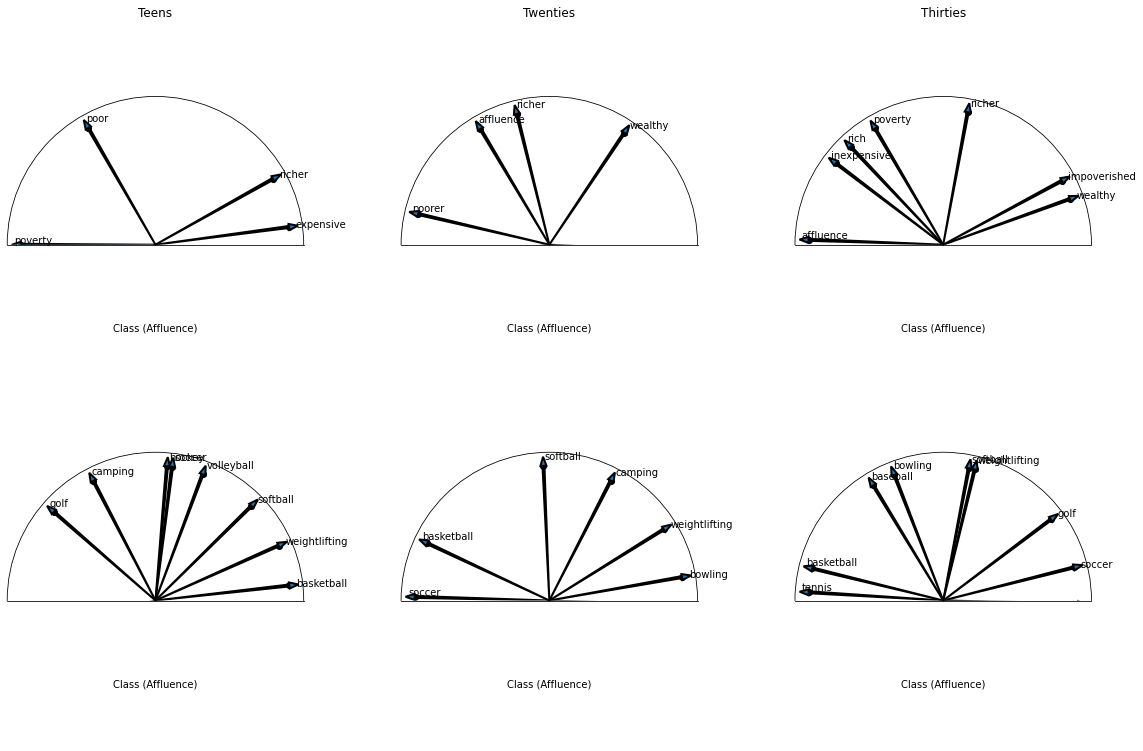

In [134]:
from matplotlib import pyplot as plt

figa_words = ["impoverished", "inexpensive", "poverty", "poor", "poorer",
             "rich", "richer", "affluence", "expensive", "wealthy"]

def get_word_angles(model, dimensions, words):
    res = []
    for w in words:
        try:
            res.append((w, get_angle(model[w], dimensions["AFFLUENCE"])))
        except KeyError:
            continue
    return res

figa_data = [get_word_angles(model10, dimensions10, figa_words),
             get_word_angles(model20, dimensions20, figa_words),
             get_word_angles(model30, dimensions30, figa_words)]

fig= plt.figure(figsize=(20,12))
titles = ["Teens", "Twenties", "Thirties"]
for i, data in enumerate(figa_data):
    ax = fig.add_subplot(2, 3, i+1, polar=True)
    ax.set_thetamin(0)
    ax.set_thetamax(180) 
    ax.set_title(titles[i])
    for d in data:
        ax.plot([d[1]], [1.0], "o", c="black")
        ax.arrow(d[1], 0, 0, 1, width=0.015, lw=2, zorder=5)
        ax.annotate(d[0], xy=(d[1], 1), xytext=(d[1]-.01, 1.05))
    ax.set_rmax(1.1)
    ax.set_rticks([])
    ax.set_xticks([])
    ax.set_xlabel("Class (Affluence)")

figb_words = ["camping", "boxing", "weightlifting", "bowling", "hockey",
             "baseball", "basketball", "soccer", "softball", "volleyball",
             "tennis", "golf"]

figb_data = [get_word_angles(model10, dimensions10, figb_words),
             get_word_angles(model20, dimensions20, figb_words),
             get_word_angles(model30, dimensions30, figb_words)]

for i, data in enumerate(figb_data):
    ax = fig.add_subplot(2, 3, i+4, polar=True)
    ax.set_thetamin(0)
    ax.set_thetamax(180) 
    for d in data:
        ax.plot([d[1]], [1.0], "o", c="black")
        ax.arrow(d[1], 0, 0, 1, width=0.015, lw=2, zorder=5)
        ax.annotate(d[0], xy=(d[1], 1), xytext=(d[1]-.01, 1.05))
    ax.set_rmax(1.1)
    ax.set_rticks([])
    ax.set_xticks([])
    ax.set_xlabel("Class (Affluence)")
    
plt.show()        


Class words don't separate as neatly along the affluence dimension as they do in the paper. This is probably due to the smaller dataset and fewer examples of class / affluence words.

Next find projections for music genres along race / class dimensions.

In [37]:
music = ["opera", "jazz", "rap", "techno", "bluegrass", "punk"]
# Music Projections
mp = {"Music Projections 10s": {m: (scalar_projection(model10[m], dimensions10["RACE"]),
                                    scalar_projection(model10[m], dimensions10["AFFLUENCE"])) for m in music},
      "Music Projections 20s": {m: (scalar_projection(model20[m], dimensions20["RACE"]),
                                    scalar_projection(model20[m], dimensions20["AFFLUENCE"])) for m in music},
      "Music Projections 30s": {m: (scalar_projection(model30[m], dimensions30["RACE"]),
                                    scalar_projection(model30[m], dimensions30["AFFLUENCE"])) for m in music}}


Recreate Figure 3 with data from the blog dataset, split up by age group. This should reveal differences in perceived race/class of the listed music genres based on the age range.

Rather than creating a secondary axis, the projection data is scaled to match the proportion of the survey responses.

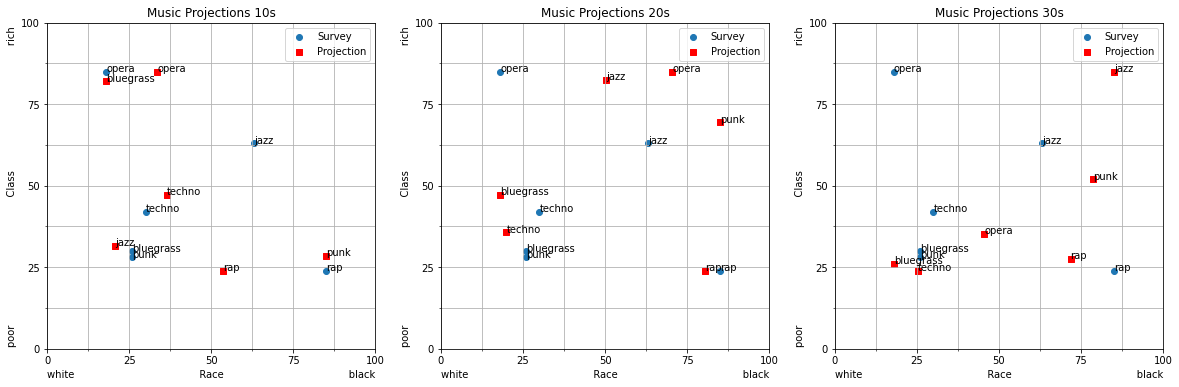

In [67]:
from matplotlib import pyplot as plt

# Plot the survey data - estimated from the graph
survey_data = {"opera": (18, 85),
              "jazz": (63, 63),
              "rap": (85,24),
              "techno": (30,42),
              "bluegrass": (26, 30),
              "punk": (26, 28)}

fig, axs = plt.subplots(1, 3, figsize=(20,6))
s_xs = np.array([v[0] for v in survey_data.values()])
s_ys = np.array([v[1] for v in survey_data.values()])
 
for ax in axs:    
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])
    ax.set_xlabel(f"white{' '*40}Race{' '*40}black")
    ax.set_ylabel(f"poor {' '*40}Class{' '*40}rich")
    ax.set_xticks(np.arange(0, 125, 25))
    ax.set_xticks(np.arange(12.5, 100, 25), minor=True)    
    ax.set_yticks(np.arange(0, 125, 25))
    ax.set_yticks(np.arange(12.5, 100, 25), minor=True)
    ax.grid(True, which="both", axis="both")
    
    ax.scatter(s_xs, s_ys)

    for k, v in survey_data.items():
        ax.annotate(k, v)
        

axnum = 0
def transform(x, bounds_from, bounds_to):
    """
    Scale X from range bounds_from to range bounds_to
    bounds_from and bounds_to should be a tuple of (lower_bound, upper_bound)
    """
    proportion = (x - bounds_from[0]) / (bounds_from[1] - bounds_from[0])    
    return bounds_to[0] + (proportion * (bounds_to[1]-bounds_to[0]))

survey_range_x = (min(s_xs), max(s_xs))
survey_range_y = (min(s_ys), max(s_ys))

for title, pdict in mp.items():
    ax = axs[axnum]
    ax.set_title(title)
    
    p_xs = np.array([v[0] for v in pdict.values()])
    p_ys = np.array([v[1] for v in pdict.values()]) 
    p_range_x = (min(p_xs), max(p_xs))
    p_range_y = (min(p_ys), max(p_ys))
    
    for k, v in pdict.items():
        xt = transform(v[0], p_range_x, survey_range_x)
        yt = transform(v[1], p_range_y, survey_range_y)
        ax.scatter(xt, yt, c="red", marker="s")
        ax.annotate(k, (xt, yt))    
    ax.legend(labels=["Survey", "Projection"])
    axnum += 1
    
    
plt.show()
